In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [2]:
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
   

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    fig, ax = plt.subplots(figsize=(14,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.grid(False)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Analysis

In [3]:
# Prepare data
demographic = pd.read_csv('../data/processed/demographic.csv')
severity = pd.read_csv('../data/processed/severity.csv', index_col=0)
features = demographic.columns 
X = demographic.astype(np.float64)
y = (severity >= 4).sum(axis=1)

In [4]:
needs_to_label = {0:'no needs', 1:'low_needs', 2:'moderate needs', 3:'high needs', 4:'very high needs'}
labels = ["no needs", "low needs", "moderate needs", "high needs", "very high needs"]
severity_to_needs = {0:0, 1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:4, 8:4}
y = np.array([severity_to_needs[i] for i in y])
# Color vector, for illustration purposes
colors = {0:'b', 1:'r', 2:'g', 3:'c', 4:'y'}
y_c = np.array([colors[i] for i in y])

### Class Balance

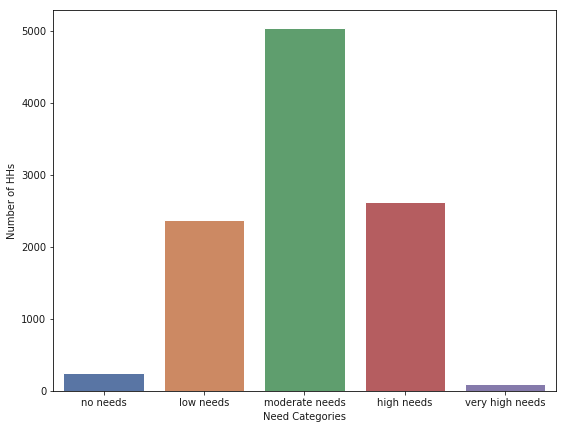

In [5]:
categories, counts = np.unique(y, return_counts=True)
fig, ax = plt.subplots(figsize=(9, 7))
sb.set(style="whitegrid")
sb.barplot(labels, counts, ax=ax, tick_label=labels)
ax.set(xlabel='Need Categories',
       ylabel='Number of HHs');

Heavy class imbalances. Use appropriate scoring metrics/measures.

# Imbalanced learning

In [6]:
from collections import Counter
from sklearn.model_selection import train_test_split
from imblearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import confusion_matrix
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import balanced_accuracy_score
from scipy.stats import randint, uniform

/home/muhadriy/.conda/envs/ml/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

In [8]:
print('Training target statistics: {}'.format(Counter(y_train)))
print('Testing target statistics: {}'.format(Counter(y_test)))

Training target statistics: Counter({2: 4025, 3: 2094, 1: 1900, 0: 202, 4: 81})
Testing target statistics: Counter({2: 1007, 3: 523, 1: 475, 0: 51, 4: 20})


In [9]:
from sklearn.metrics import balanced_accuracy_score
from mlens.metrics import make_scorer
accuracy_scorer = make_scorer(balanced_accuracy_score, greater_is_better=True)

[MLENS] backend: threading


### Stacking

In [10]:
from mlens.ensemble import SuperLearner,SequentialEnsemble
from mlens.model_selection import Evaluator
from mlens.config import set_backend, get_backend

In [11]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [72]:
first_level = [KNeighborsClassifier(), GaussianNB(), SVC(gamma='auto', probability=True)]
second_level = [ExtraTreesClassifier(n_estimators=100), GradientBoostingClassifier(), BaggingClassifier()]

In [76]:
ensemble = SuperLearner(n_jobs=-1, random_state=42, verbose=2)
ensemble.add(first_level)
ensemble.add(second_level, proba=True)
ensemble.add_meta(LogisticRegression(max_iter=3000, solver='lbfgs', multi_class='auto'));

In [77]:
ensemble.fit(X_train, y_train);


Fitting 3 layers
Processing layer-1             done | 00:00:35
Processing layer-2             done | 00:00:03
Processing layer-3             done | 00:00:00
Fit complete                        | 00:00:39



Predicting 3 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Processing layer-3             done | 00:00:00
Predict complete                    | 00:00:01
Balanced accuracy: 0.21
Classification report: 
                       pre       rec       spe        f1       geo       iba       sup

       no needs       0.00      0.00      1.00      0.00      0.00      0.00        51
      low needs       0.45      0.04      0.99      0.07      0.19      0.03       475
 moderate needs       0.49      0.97      0.06      0.65      0.24      0.06      1007
     high needs       0.51      0.06      0.98      0.10      0.23      0.05       523
very high needs       0.00      0.00      1.00      0.00      0.00      0.00        20

    avg / total       0.47      0.49      0.54      0.36      0.22      0.05      2076

Normalized confusion matrix


/home/muhadriy/.conda/envs/ml/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


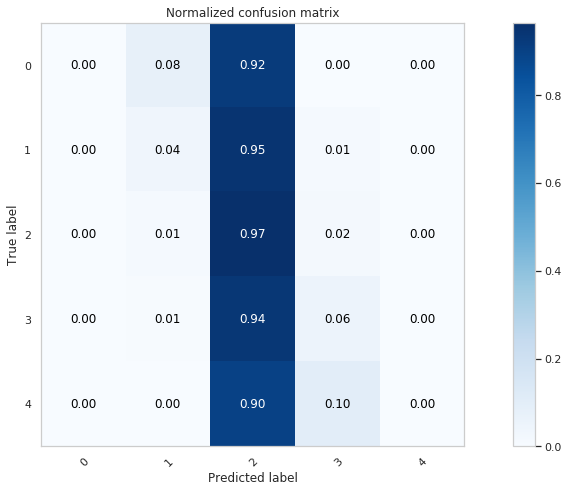

In [78]:
y_pred = ensemble.predict(X_test);
print('Balanced accuracy: {:.2f}'.format(balanced_accuracy_score(y_test,y_pred)))
print('Classification report: ')
print(classification_report_imbalanced(y_test, y_pred, target_names=labels))
plot_confusion_matrix(y_test, y_pred, classes=np.unique(y), normalize=True)